# Basic Image Classification with Feedforward NN and LetNet5

All libraries we introduced in the last chapter provide support for convolutional layers. We are going to illustrate the LeNet5 architecture using the most basic MNIST handwritten digit dataset, and then use AlexNet on CIFAR10, a simplified version of the original ImageNet to demonstrate the use of data augmentation.
LeNet5 and MNIST using Keras.

## Imports

In [45]:
%matplotlib inline
from random import randint
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras import models, layers
from keras.datasets import mnist
from keras.utils import np_utils
import keras.backend as K
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Dense, Dropout, Flatten
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Load MNIST Database

The original MNIST dataset contains 60,000 images in 28x28 pixel resolution with a single grayscale containing handwritten digits from 0 to 9. A good alternative is the more challenging but structurally similar Fashion MNIST dataset that we encountered in Chapter 12 on Unsupervised Learning.

We can load it in keras out of the box:

In [2]:
# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(X_train))
print("The MNIST database has a test set of %d examples." % len(X_test))

The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


In [3]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

## Visualize Data

### Visualize First 10 Training Images

The below figure shows the first ten images in the dataset and highlights significant variation among instances of the same digit. On the right, it shows how the pixel values for an indivual image range from 0 to 255.

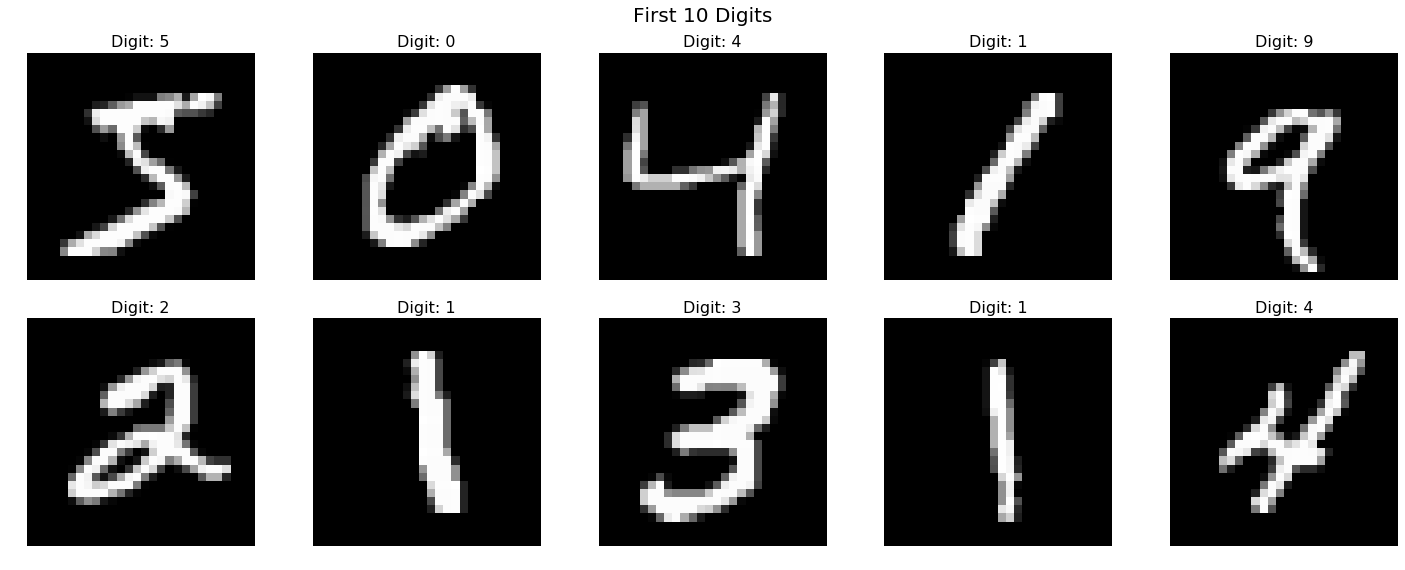

In [4]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
    ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)
fig.suptitle('First 10 Digits', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)

### Show random image in detail

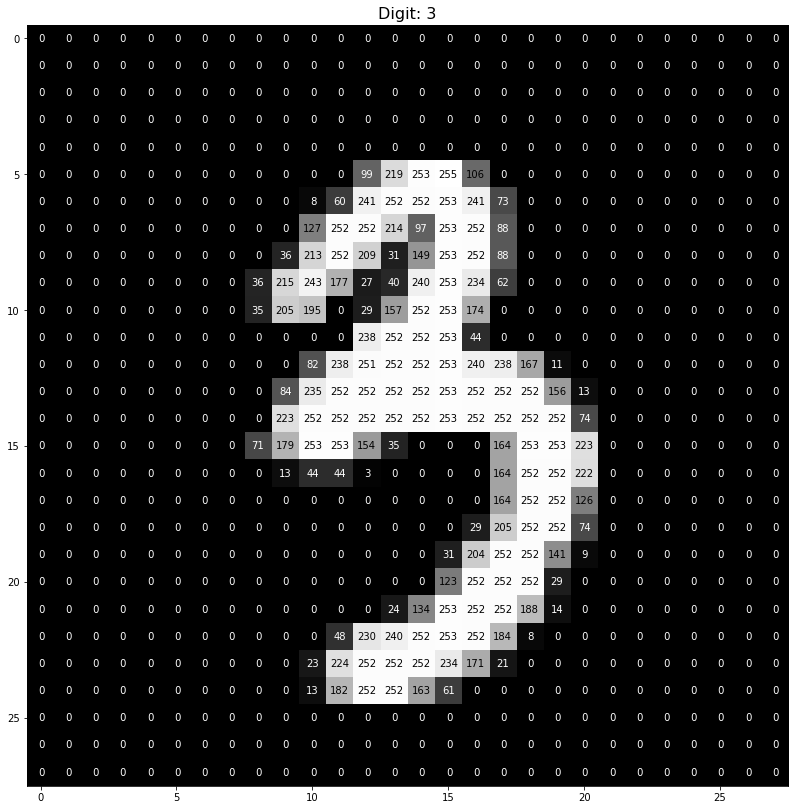

In [5]:
fig, ax = plt.subplots(figsize = (14, 14)) 

i = randint(0, len(X_train))
img = X_train[i]

ax.imshow(img, cmap='gray')
ax.set_title('Digit: {}'.format(y_train[i]), fontsize=16)

width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        ax.annotate('{:2}'.format(img[x][y]), 
                    xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Prepare Data

### Rescale pixel values

We rescale the pixel values to the range [0, 1] to normalize the training data and faciliate the backpropagation process and convert the data to 32 bit floats that reduce memory requirements and computational cost while providing sufficient precision for our use case:

In [4]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255 

### One-Hot Label Encoding using Keras

Print first ten labels

In [5]:
print('Integer-valued labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]


We also need to convert the one-dimensional label to 10-dimensional one-hot encoding to make it compatible with the cross-entropy loss that receives a 10-class softmax output from the network:

In [6]:
# one-hot encode the labels
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [7]:
# print first ten (one-hot) training labels
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

## Feed-Forward NN

### Model Architecture

In [35]:
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [37]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

### Calculate Baseline Classification Accuracy

In [8]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 10.4200%


### Callback for model persistence

In [ ]:
mnist_path = 'models/mnist.ffn.best.hdf5'

In [39]:
checkpointer = ModelCheckpoint(filepath=mnist_path, 
                               verbose=1, 
                               save_best_only=True)

### Train the Model

In [40]:
hist = model.fit(X_train, 
                 y_train, 
                 batch_size=128, 
                 epochs=10,
                 validation_split=0.2, 
                 callbacks=[checkpointer],
                 verbose=1, 
                 shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 76us/step - loss: 12.3566 - acc: 0.2327 - val_loss: 11.6693 - val_acc: 0.2757

Epoch 00001: val_loss improved from inf to 11.66925, saving model to mnist.model.best.hdf5
Epoch 2/10
48000/48000 [==============================] - 3s 69us/step - loss: 11.6842 - acc: 0.2748 - val_loss: 11.6416 - val_acc: 0.2775

Epoch 00002: val_loss improved from 11.66925 to 11.64164, saving model to mnist.model.best.hdf5
Epoch 3/10
48000/48000 [==============================] - 3s 67us/step - loss: 11.5629 - acc: 0.2825 - val_loss: 11.6896 - val_acc: 0.2746

Epoch 00003: val_loss did not improve from 11.64164
Epoch 4/10
48000/48000 [==============================] - 3s 67us/step - loss: 11.5198 - acc: 0.2851 - val_loss: 11.5825 - val_acc: 0.2812

Epoch 00004: val_loss improved from 11.64164 to 11.58248, saving model to mnist.model.best.hdf5
Epoch 5/10
48000/48000 [==============================]

### Load the Best Model

In [41]:
# load the weights that yielded the best validation accuracy
model.load_weights(mnist_path)

### Test Classification Accuracy

In [44]:
# evaluate test accuracy
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

print(f'Test accuracy: {accuracy:.2%}')

Test accuracy: 37.36%


## LeNet5

In [33]:
K.clear_session()

We can define a simplified version of LeNet5 that omits the original final layer containing radial basis functions as follows, using the default ‘valid’ padding and single step strides unless defined otherwise:

In [34]:
lenet5 = Sequential([
    Conv2D(filters=6, kernel_size=5, activation='relu', input_shape=(28, 28, 1), name='CONV1'),
    AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid', name='POOL1'),
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', name='CONV2'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL2'),
    Conv2D(filters=120, kernel_size=(5, 5), activation='tanh', name='CONV3'),
    Flatten(name='FLAT'),
    Dense(units=84, activation='tanh', name='FC6'),
    Dense(units=10, activation='softmax', name='FC7')
])

The summary indicates that the model thus defined has over 300,000 parameters:

In [35]:
lenet5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 24, 24, 6)         156       
_________________________________________________________________
POOL1 (AveragePooling2D)     (None, 23, 23, 6)         0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 19, 19, 16)        2416      
_________________________________________________________________
POOL2 (AveragePooling2D)     (None, 9, 9, 16)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 5, 5, 120)         48120     
_________________________________________________________________
FLAT (Flatten)               (None, 3000)              0         
_________________________________________________________________
FC6 (Dense)                  (None, 84)                252084    
__________

We compile using crossentropy loss and the original stochastic gradient optimizer:

In [36]:
lenet5.compile(loss=categorical_crossentropy,
               optimizer='SGD',
               metrics=['accuracy'])

In [37]:
lenet_path = 'models/mnist.lenet.best.hdf5'

In [38]:
checkpointer = ModelCheckpoint(filepath=lenet_path,
                               verbose=1,
                               save_best_only=True)

Now we are ready to train the model. The model expects 4D input so we reshape accordingly. We use the standard batch size of 32, 80-20 train-validation split, use checkpointing to store the model weights if the validation error improves, and make sure the dataset is randomly shuffled:

In [42]:
training = lenet5.fit(X_train.reshape(-1, 28, 28, 1),
                      y_train,
                      batch_size=32,
                       epochs=50,
                       validation_split=0.2, # use 0 to train on all data
                       callbacks=[checkpointer],
                       verbose=1,
                       shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 3s 63us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.0058 - val_acc: 0.9994

Epoch 00001: val_loss improved from inf to 0.00576, saving model to models/mnist.lenet.best.hdf5
Epoch 2/50
48000/48000 [==============================] - 3s 62us/step - loss: 0.0049 - acc: 0.9995 - val_loss: 0.0058 - val_acc: 0.9993

Epoch 00002: val_loss did not improve from 0.00576
Epoch 3/50
48000/48000 [==============================] - 3s 66us/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0063 - val_acc: 0.9992

Epoch 00003: val_loss did not improve from 0.00576
Epoch 4/50
48000/48000 [==============================] - 3s 66us/step - loss: 0.0044 - acc: 0.9996 - val_loss: 0.0063 - val_acc: 0.9989

Epoch 00004: val_loss did not improve from 0.00576
Epoch 5/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0065 - val_acc: 0.9988

Epoch 0000


Epoch 00043: val_loss did not improve from 0.00576
Epoch 44/50
48000/48000 [==============================] - 3s 67us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9978

Epoch 00044: val_loss did not improve from 0.00576
Epoch 45/50
48000/48000 [==============================] - 3s 65us/step - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0082 - val_acc: 0.9977

Epoch 00045: val_loss did not improve from 0.00576
Epoch 46/50
48000/48000 [==============================] - 3s 71us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9978

Epoch 00046: val_loss did not improve from 0.00576
Epoch 47/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9981

Epoch 00047: val_loss did not improve from 0.00576
Epoch 48/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9977

Epoch 00048: val_loss did not improve from 0.0057

On a single GPU, 50 epochs take around 2.5 minutes, resulting in a test accuracy of 99.19%, almost exactly the same result as for the original LeNet5:

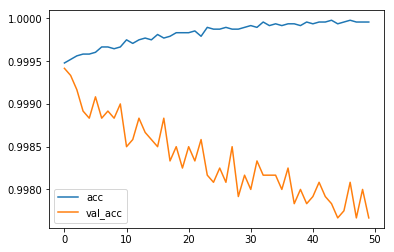

In [48]:
pd.DataFrame(training.history)[['acc','val_acc']].plot();

In [49]:
# evaluate test accuracy
accuracy = lenet5.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(accuracy))

Test accuracy: 99.19%


## Summary

For comparison, a simple two-layer feedforward network achieves only 37.36% test accuracy. 

The LeNet5 improvement on MNIST is, in fact, modest. Non-neural methods have also achieved classification accuracies greater than or equal to 99%, including K-Nearest Neighbours or Support Vector Machines. CNNs really shine with more challenging datasets as we will see next.